# Coding Persistent Cup Length Diagram

In this Jupyter Notebook we write up the necessary functions for calculating the Persistent Cup Length Diagram of a simplicial filtration adapting algorithms from "Persistent cup-length" by Contesotto M, Memoli F, Stefanou A, Zhou L and using the Oineus python module by Nigmetov A which you may need to pip install before running this notebook.

One small note is that Algorithm 3 from "Persistent cup-length" has a subtle error in its last line that is corrected here. 

Below we define all of the functions needed for the implementation:

In [17]:
#import libraries
import matplotlib.pyplot as plt
import oineus as oin
import numpy as np
from copy import deepcopy

#Key functions: Cup Product, Dualize cells, Pivot Columns, Get U matrix, Get Cocycles (TB Added)
#May be a good idea to work out how to remove verbose barcodes when doing Vietoris Rips calculations

def cup_Product(sigma_1,sigma_2, cells):
    #cells is a list of simplices, sigma_i is an element of the cohomology ring given by the ids of the simplices.
    #initialize output
    sigma = []
    #Check for 0 input
    if (sigma_1 == [] or sigma_2 == []):
        return sigma
    #Efficiencies to implement later: Dimension bound to skip a loop
    for i in range(0,len(sigma_1)):
            a = cells[sigma_1[i]].vertices
            for j in range(0,len(sigma_2)):
                b = cells[sigma_2[j]].vertices
                if(a[-1] == b[0]):
                    c = a+b[1:len(b)]
                    #Check if the result is in cells. 
                    #Efficiency to implement later: Reduce range to just those simplices of the right dimension. maybe using dim first dim last in filtration
                    for k in range(0,len(cells)):
                        if(c==cells[k].vertices):
                            sigma.append(k)
    sigma.sort()
    return sigma

def get_Pivots(Rmatrix):
    #Get the pivot columns from the reduced coboundary matrix.
    #Initalise output
    Pivots_R = []
    for i in range(0,len(Rmatrix)):
        if(Rmatrix[i] != []):
            Pivots_R.append(Rmatrix[i][-1])
    return Pivots_R

def matrix_Multiplication_for_Sparse_Arrays(A,B):
    #Given the sparse matrix notation of oineus which lists columns with a nonzero entry assuming Z_2 coefficients, compute their matrix multiplication A.B
    #I am assuming size A = size B
    AB = []
    m = len(B)
    for j in range(m):
        C = set([])
        for i in B[j]:
            C = C^set(A[i])
        AB.append(list(C))
    for i in range(m):
        AB[i].sort()
    return AB

def get_Row_Operation_Matrix( R):
    #Given reduced matrix R get the Row Operation Matrix U needed to check for coboundaries
    #Initialise output
    U = []
    Rm = deepcopy(R)
    m = len(Rm)
    for j in range(m):
        #make U the identity matrix
        U.append([j])
    for j in range(m):
        #Go over each column to reduce
        Rm[j].sort()
        verts = Rm[j]
        #Check for empty column
        if (verts != []):
            E = []
            for n in range(m):
                #make U the identity matrix
                E.append([n])
            #select row of Rmatrix
            for i in verts[0:len(verts)-1]:
                #Update each column of Rmatrix
                for k in range(m):
                    if (verts[-1] in Rm[k]):
                        if (i in Rm[k]):
                            #remove i from Rmatrix[k]
                            Rm[k].remove(i)
                        else:
                            Rm[k].append(i)
                #Update U to account for the above row operation            
                E[verts[-1]].append(i)
            U = matrix_Multiplication_for_Sparse_Arrays(E,U)
    return U


class Cocycle:
    def __init__(self, simplices, birth, death):
        self.simplices = simplices
        self.birth = birth
        self.death = death
        self.life = [birth, death]
        self.birth_index = 0
        self.death_index = 0
        
#test = Cocycle([[2,12,48],[1,3,5]],0.2,0.5)

def get_Cocycle_Reps(dcmp,fil,V, dim_bound):
    #ensure dcmp has been reduced before calling this function
    Cocycle_Reps = []
    for i in range(1,dim_bound+1):
        dgms = dcmp.diagram(fil).in_dimension(i)
        indx_dgms = dcmp.diagram(fil).index_diagram_in_dimension(i)
        for j in range(len(dgms)):
            sigma_idx = fil.id_by_sorted_id(indx_dgms[j][0])
            new_Cocycle = Cocycle(V[len(V)-1-sigma_idx],dgms[j][0],dgms[j][1])
            Cocycle_Reps.append(new_Cocycle)
    return Cocycle_Reps

def check_Coboundary(Pivots, U, sigma, length):
    vector = [[]]
    for k in sigma:
        if k >= length:
            vector[0].append(k)
    image = matrix_Multiplication_for_Sparse_Arrays(U,vector)
    result = []
    for k in image[0]:
        if k>= length:
            result.append(k)
    sigma_is_coboundary = set(result).issubset(Pivots)
    return sigma_is_coboundary        

def Persistent_Cup_Diagram(dim_bound, Cosimplices, Rmatrix, Representative_Cocycles ):
    #representative cocycles must have birth time and death time 
    #they should be ordered first by increasing death time and then in increasing birth time
    #Cosimplices should be ordered from dimension 1 to k+1
    #Potentially rewrite this so that it just inputs the filtration and a dimension bound.
    B = [[]]
    #Note that this puts the index one below the index listed in Algorithm 2
    for barcode in Representative_Cocycles:
        if len(Cosimplices[barcode.simplices[0]].vertices) != 1:
            B[0].append(barcode)
    b_time = []
    d_time = []
    for barcode in B[0]:
        if (barcode.birth in b_time) == False:
            barcode.birth_index = len(b_time)
            b_time.append(barcode.birth)
        else:
            for k in range(len(b_time)):
                if barcode.birth == b_time[k]:
                    barcode.birth_index = k
        if (barcode.death in d_time) == False:
            barcode.death_index = len(d_time)
            d_time.append(barcode.death)
        else: 
            for k in range(len(d_time)):
                if barcode.death == d_time[k]:
                    barcode.death_index = k
    #The index stuff is to avoid having float == float statements later on though there are some in determining the indices
    m = len(Cosimplices)
    Pivots = get_Pivots(Rmatrix)
    l = 1
    U = get_Row_Operation_Matrix(Rmatrix)
    A_0 = np.zeros((len(b_time),len(d_time)))
    A_1 = np.zeros((len(b_time),len(d_time)))
    A = []
    A.append(A_0)
    A.append(A_1)
    for barcode in B[0]:
        i = barcode.birth_index
        j = barcode.death_index
        A[1][i,j] = 1
    while ((A[l] != A[l-1]).any()) and (l <= dim_bound-1):
        A.append(deepcopy(A[l]))
        B.append([])
        for barcode_1 in B[0]:
            for barcode_2 in B[l-1]:
                sigma = cup_Product(barcode_1.simplices,barcode_2.simplices, Cosimplices)
                if sigma == []:
                    continue
                death_index = min(barcode_1.death_index, barcode_2.death_index)
                index_set = []
                for k in range(len(b_time)):
                    if b_time[k] <= d_time[death_index]:
                        index_set.append(k)
                birth_index = max(index_set)
                s = 0
                for tau in Cosimplices:
                    if tau.value <= b_time[birth_index]:
                        s+= 1
                while (check_Coboundary(Pivots, U, sigma, m+1-s) == True) and (birth_index >= 0):
                    birth_index = birth_index-1
                    s = 0
                    for tau in Cosimplices:
                        if tau.value <= b_time[birth_index]:
                            s+= 1
                if b_time[birth_index] < d_time[death_index]:
                    new_Cocycle = Cocycle(sigma,b_time[birth_index], d_time[death_index])
                    new_Cocycle.birth_index = birth_index
                    new_Cocycle.death_index = death_index
                    B[l].append(deepcopy(new_Cocycle))
                    A[l+1][birth_index,death_index] = l+1
        l+=1
    return [A[l],b_time,d_time]


## Example 1: Torus

We begin by showing how to use these functions on a simplicial model of a torus. 

First we specify the simplices needed for this model. These are written as objects of the class oin.Simplex which requires the specification of the vertices (listed in increasing order) and the time at which the simplex is added in the filtration. We put these simplices in a list and create a filtration from oin.Filtration(Simplices).

These simplex objects in the filtration also have the attribute id and the $0$-simplices should be listed so that their vertex matches their simplex id.

In [2]:
#simplicial model of a torus.

#vertices
v0 = oin.Simplex([0],0.1)
v1 = oin.Simplex([1],0.2)
v2 = oin.Simplex([2],0.3)
v3 = oin.Simplex([3],0.4)
v4 = oin.Simplex([4],0.5)
v5 = oin.Simplex([5],0.6)
v6 = oin.Simplex([6],0.7)
v7 = oin.Simplex([7],0.8)
v8 = oin.Simplex([8],0.9)

#edges
e1 = oin.Simplex([0,1],1.1)
e2 = oin.Simplex([0,2],1.1)
e3 = oin.Simplex([0,3],1.1)
e4 = oin.Simplex([0,4],1.2)
e5 = oin.Simplex([0,6],1.2)
e6 = oin.Simplex([0,8],1.2)
e7 = oin.Simplex([1,2],1.3)
e8 = oin.Simplex([1,4],1.3)
e9 = oin.Simplex([1,5],1.3)
e10 = oin.Simplex([1,6],1.4)
e11 = oin.Simplex([1,7],1.4)
e12 = oin.Simplex([2,3],1.4)
e13 = oin.Simplex([2,5],1.5)
e14 = oin.Simplex([2,7],1.5)
e15 = oin.Simplex([2,8],1.5)
e16 = oin.Simplex([3,4],1.6)
e17 = oin.Simplex([3,5],1.6)
e18 = oin.Simplex([3,6],1.6)
e19 = oin.Simplex([3,7],1.7)
e20 = oin.Simplex([4,5],1.7)
e21 = oin.Simplex([4,7],1.7)
e22 = oin.Simplex([4,8],1.8)
e23 = oin.Simplex([5,6],1.8)
e24 = oin.Simplex([5,8],1.8)
e25 = oin.Simplex([6,7],1.9)
e26 = oin.Simplex([6,8],1.9)
e27 = oin.Simplex([7,8],1.9)

#triangles

t1 = oin.Simplex([0,1,4], 2.2)
t2 = oin.Simplex([0,1,6], 2.2)
t3 = oin.Simplex([0,2,3], 2.2)
t4 = oin.Simplex([0,2,8], 2.4)
t5 = oin.Simplex([0,3,4], 2.4)
t6 = oin.Simplex([0,6,8], 2.4)
t7 = oin.Simplex([1,2,5], 2.6)
t8 = oin.Simplex([1,2,7], 2.6)
t9 = oin.Simplex([1,4,5], 2.6)
t10 = oin.Simplex([1,6,7], 2.8)
t11 = oin.Simplex([2,3,5], 2.8)
t12 = oin.Simplex([2,7,8], 2.8)
t13 = oin.Simplex([3,4,7], 2.8)
t14 = oin.Simplex([3,5,6], 2.8)
t15 = oin.Simplex([3,6,7], 2.9)
t16 = oin.Simplex([4,5,8], 2.9)
t17 = oin.Simplex([4,7,8], 2.9)
t18 = oin.Simplex([5,6,8], 2.9)

Simplices = [v0, v1, v2, v3, v4, v5, v6, v7, v8, e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15, e16, e17, e18, e19, e20, e21, e22, e23, e24, e25, e26, e27, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14, t15, t16, t17, t18]

fil = oin.Filtration(Simplices)


Now that we have a filtration we use the functions in Oineus to get the VRU Decomposition of this filtration. We will need the V and R matrices of this filtration which are written in a sparse matrix notation ([[0], [1], [0,2]] encodes the matrix with 1s in the [1,1], [2,2], [3,3] and [1,3] coordinates and zeros elsewhere). For our purposes, these matrices have coordinates in $\mathbb{Z}_2$

We note that we will want to use the dualized form of this to get Cocycle Representatives which reverses the order in which our cosimplices are listed i.e. if we have $n$ Simplices in Total, the dual simplex to simplex $i$, is indexed as $n-1-i$ in the matrices V and R. To refer to these cosimplices we create a list sorting our simplices in order of decreasing id.

In [3]:
# cohomology
dualize = True
# create VRU decomposition object, does not perform reduction yet
dcmp = oin.Decomposition(fil, dualize)

rp = oin.ReductionParams()

rp.compute_u = rp.compute_v = True
rp.n_threads = 1
# perform reduction
dcmp.reduce(rp)

# now we can acess V, R and U
# indices are sorted_ids of simplices == indices in fil.cells()
V = dcmp.v_data
R = dcmp.r_data

simplices = fil.simplices()
cosimplices = sorted(simplices, key= lambda x: x.id , reverse = True)

#Below we get the coboundary of the vertex [1]
print(R[52])
for sigma_ids in R[52]:
    print(cosimplices[sigma_ids])

[34, 35, 36, 37, 38, 44]
([1, 7], 1.4)
([1, 6], 1.4)
([1, 5], 1.3)
([1, 4], 1.3)
([1, 2], 1.3)
([0, 1], 1.1)


### Persistence Diagrams

Using this decomposition, we can get the Persistent Cohomology diagrams in each dimension using the following methods which lists the barcodes in each dimension

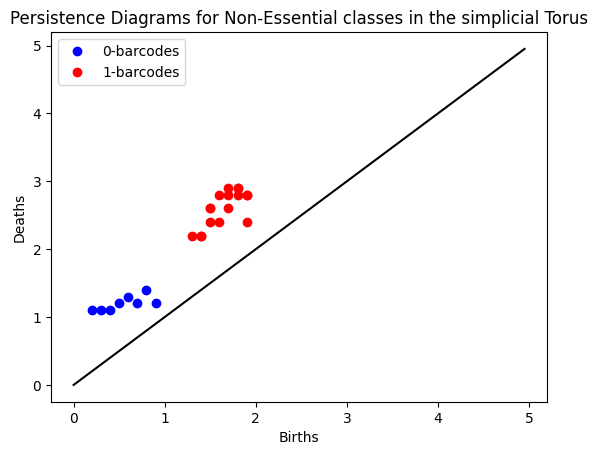

In [4]:
dgms = dcmp.diagram(fil)

dgm_0 = dcmp.diagram(fil).in_dimension(0)
assert type(dgm_0) is np.ndarray
dgm_0_x = dgm_0[:,0]
dgm_0_y = dgm_0[:,1]
dgm_1 = dcmp.diagram(fil).in_dimension(1)
dgm_1_x = dgm_1[:,0]
dgm_1_y = dgm_1[:,1]
#Alternative notation
dgm_2 = dcmp.diagram(fil)[2]
dgm_2_x = dgm_2[:,0]
dgm_2_y = dgm_2[:,1]

# To load the display window
plt.plot(dgm_0_x,dgm_0_y, 'bo', label = '0-barcodes')
plt.plot(dgm_1_x,dgm_1_y, 'ro', label = '1-barcodes')
X = np.arange(0, 5, 0.05)
Y = X
plt.plot(X,Y, 'k-')
#plt.plot(dgm_2_x,dgm_2_y, 'go', label = '2-barcodes')

plt.xlabel("Births")
plt.ylabel("Deaths")
plt.title("Persistence Diagrams for Non-Essential classes in the simplicial Torus")

plt.legend()

plt.show()
#print("1-dimensional persistence diagram is")
#print("2-dimensional persistence diagram is")


### Persistent Cup-Length

We now go over how to use this information to calculate the Persistent Cup-Length Diagram associated to the cocycle representatives gained from this R and V Matrix.

Following Algorithm 2 in "Persistent Cup-Length" we need A dimension bound, which is implicit in explicit filtrations, the ordered list of cosimplices (above) the column reduced R Matrix (above) and the barcodes annotated by their representative cocycles listed first in increasing order of death times, then in the increasing order of birth times. 

We get these annotated barcodes by the get_Cocycle_Reps function which pulls out all of the barcodes from the oineus decomposition and pulls out the corresponding column of the V matrix which lists the cosimplices that compose the cocycle representing this barcode

In [20]:
RCocycles = get_Cocycle_Reps(dcmp,fil,V,2)
for i in range(len(RCocycles)):
    print(RCocycles[i].simplices, RCocycles[i].birth,RCocycles[i].death)

[18] 1.9 2.8
[19] 1.9 2.4
[20] 1.9 2.8
[21] 1.8 2.9
[22] 1.8 2.8
[21, 23] 1.8 2.9
[24] 1.7 2.8
[25] 1.7 2.6
[24, 26] 1.7 2.9
[21, 22, 23, 24, 26, 27] 1.6 inf
[28] 1.6 2.8
[29] 1.6 2.4
[30] 1.5 2.4
[31] 1.5 2.6
[32] 1.5 2.6
[33] 1.4 2.2
[35] 1.4 2.2
[37] 1.3 2.2
[18, 21, 22, 23, 28, 31, 32, 38] 1.3 inf
[0] 2.9 inf


We then sort these cocycles first in increasing order of death time, then by increasing order of birth time.

In [21]:
ReorderedCocycles = sorted(RCocycles, key= lambda x: (x.death, x.birth), reverse=False)

print("")

for i in range(len(ReorderedCocycles)):
    print(ReorderedCocycles[i].simplices,ReorderedCocycles[i].life)


[37] [np.float64(1.3), np.float64(2.2)]
[33] [np.float64(1.4), np.float64(2.2)]
[35] [np.float64(1.4), np.float64(2.2)]
[30] [np.float64(1.5), np.float64(2.4)]
[29] [np.float64(1.6), np.float64(2.4)]
[19] [np.float64(1.9), np.float64(2.4)]
[31] [np.float64(1.5), np.float64(2.6)]
[32] [np.float64(1.5), np.float64(2.6)]
[25] [np.float64(1.7), np.float64(2.6)]
[28] [np.float64(1.6), np.float64(2.8)]
[24] [np.float64(1.7), np.float64(2.8)]
[22] [np.float64(1.8), np.float64(2.8)]
[18] [np.float64(1.9), np.float64(2.8)]
[20] [np.float64(1.9), np.float64(2.8)]
[24, 26] [np.float64(1.7), np.float64(2.9)]
[21] [np.float64(1.8), np.float64(2.9)]
[21, 23] [np.float64(1.8), np.float64(2.9)]
[18, 21, 22, 23, 28, 31, 32, 38] [np.float64(1.3), np.float64(inf)]
[21, 22, 23, 24, 26, 27] [np.float64(1.6), np.float64(inf)]
[0] [np.float64(2.9), np.float64(inf)]


In [22]:
Cup_diagram = Persistent_Cup_Diagram(4, cosimplices, R, ReorderedCocycles)

Cup_diagram_Matrix = Cup_diagram[0]
b_time = Cup_diagram[1]
d_time = Cup_diagram[2]

print(Cup_diagram_Matrix)
print(b_time)
print(d_time)

[[1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 2.]]
[np.float64(1.3), np.float64(1.4), np.float64(1.5), np.float64(1.6), np.float64(1.9), np.float64(1.7), np.float64(1.8), np.float64(2.9)]
[np.float64(2.2), np.float64(2.4), np.float64(2.6), np.float64(2.8), np.float64(2.9), np.float64(inf)]


This recovers the Persistent cup length function which sends every interval whose starting point is greater than or equal to 2.9 to 2 and every interval whose starting point is between 1.3 and 2.9 to 1

## Example 2: Klein Bottle

Next we go over an example from the paper "Persistent Cup-Length" using a simplicial model for a Klein Bottle in which we add an extra simplex to kill one of the essential $1$-cocycles

In [8]:
#simplicial model of a Klein Bottle.

#vertices
w0 = oin.Simplex([0],0.1)
w1 = oin.Simplex([1],1.0)
w2 = oin.Simplex([2],1.0)
w3 = oin.Simplex([3],2.0)
w4 = oin.Simplex([4],2.0)
w5 = oin.Simplex([5],2.0)
w6 = oin.Simplex([6],2.0)
w7 = oin.Simplex([7],2.0)
w8 = oin.Simplex([8],2.0)

#edges
f1 = oin.Simplex([0,1],1.0)
f2 = oin.Simplex([0,2],1.0)
f3 = oin.Simplex([1,2],1.0)
f4 = oin.Simplex([0,3],2.0)
f5 = oin.Simplex([0,5],2.0)
f6 = oin.Simplex([0,6],2.0)
f7 = oin.Simplex([0,7],2.0)
f8 = oin.Simplex([1,3],2.0)
f9 = oin.Simplex([1,4],2.0)
f10 = oin.Simplex([1,5],2.0)
f11 = oin.Simplex([1,8],2.0)
f12 = oin.Simplex([2,3],2.0)
f13 = oin.Simplex([2,4],2.0)
f14 = oin.Simplex([2,7],2.0)
f15 = oin.Simplex([2,8],2.0)
f16 = oin.Simplex([3,4],2.0)
f17 = oin.Simplex([3,6],2.0)
f18 = oin.Simplex([3,8],2.0)
f19 = oin.Simplex([4,5],2.0)
f20 = oin.Simplex([4,6],2.0)
f21 = oin.Simplex([4,7],2.0)
f22 = oin.Simplex([5,6],2.0)
f23 = oin.Simplex([5,7],2.0)
f24 = oin.Simplex([5,8],2.0)
f25 = oin.Simplex([6,7],2.0)
f26 = oin.Simplex([6,8],2.0)
f27 = oin.Simplex([7,8],2.0)

#triangles

tr1 = oin.Simplex([0,1,2], 3.0)
tr2 = oin.Simplex([0,1,3], 2.0)
tr3 = oin.Simplex([0,1,5], 2.0)
tr4 = oin.Simplex([0,2,3], 2.0)
tr5 = oin.Simplex([0,2,7], 2.0)
tr6 = oin.Simplex([0,5,6], 2.0)
tr7 = oin.Simplex([0,6,7], 2.0)
tr8 = oin.Simplex([1,2,4], 2.0)
tr9 = oin.Simplex([1,2,8], 2.0)
tr10 = oin.Simplex([1,3,4], 2.0)
tr11 = oin.Simplex([1,5,8], 2.0)
tr12 = oin.Simplex([2,3,8], 2.0)
tr13 = oin.Simplex([2,4,7], 2.0)
tr14 = oin.Simplex([3,4,6], 2.0)
tr15 = oin.Simplex([3,6,8], 2.0)
tr16 = oin.Simplex([4,5,6], 2.0)
tr17 = oin.Simplex([4,5,7], 2.0)
tr18 = oin.Simplex([5,7,8], 2.0)
tr19 = oin.Simplex([6,7,8], 2.0)

Klein_Simplices = [w0, w1, w2, w3, w4, w5, w6, w7, w8, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, tr1, tr2, tr3, tr4, tr5, tr6, tr7, tr8, tr9, tr10, tr11, tr12, tr13, tr14, tr15, tr16, tr17, tr18, tr19]

Klein_fil = oin.Filtration(Klein_Simplices)


In [9]:
# cohomology
dualize = True
# create VRU decomposition object, does not perform reduction yet
Klein_dcmp = oin.Decomposition(Klein_fil, dualize)

rp = oin.ReductionParams()

rp.compute_u = rp.compute_v = True
rp.n_threads = 1
# perform reduction
Klein_dcmp.reduce(rp)

# now we can acess V, R and U
# indices are sorted_ids of simplices == indices in fil.cells()
Klein_V = Klein_dcmp.v_data
Klein_R = Klein_dcmp.r_data

Klein_simplices = Klein_fil.simplices()
Klein_cosimplices = sorted(Klein_simplices, key= lambda x: x.id , reverse = True)

print(Klein_R)
print(Klein_V)


[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1, 2], [1, 5], [1, 13], [2, 9], [2, 3], [4, 14], [3, 7], [4, 6], [3, 4], [5, 8], [], [6, 10], [8, 11], [7, 15], [7, 12], [8, 16], [], [9, 17], [], [10, 18], [], [], [], [], [0], [], [], [19, 20, 22, 28, 31, 35], [19, 21, 23, 25, 32, 39], [20, 21, 24, 26, 29, 40], [22, 23, 24, 27, 36, 41], [25, 26, 27, 30, 33, 37], [28, 29, 30, 34, 38, 42], [31, 32, 33, 34, 43, 44], [35, 36, 37, 38, 43, 45], []]
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [19, 20, 23, 26, 27, 29], [30], [31], [32], [33], [34], [19, 20, 22, 28, 31, 35], [36], [25, 26, 27, 30, 33, 37], [38], [19, 21, 23, 25, 32, 39], [20, 21, 24, 26, 29, 40], [22, 23, 24, 27, 36, 41], [28, 29, 30, 34, 38, 42], [19, 20, 23, 25, 28, 31, 33, 43], [31, 32, 33, 34, 43, 44], [35, 36, 37, 38, 43, 45], [46], [47], [48], [49], [50], [51], [52], [53], [

[[0.1 inf]]
[[ 2. inf]
 [ 1.  3.]]
[[ 2. inf]]


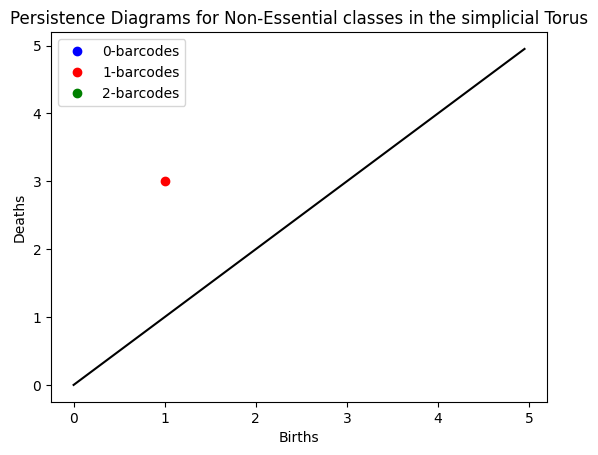

In [10]:
Klein_dgms = Klein_dcmp.diagram(Klein_fil)

Klein_dgm_0 = Klein_dcmp.diagram(Klein_fil).in_dimension(0)
assert type(dgm_0) is np.ndarray
Klein_dgm_0_x = Klein_dgm_0[:,0]
Klein_dgm_0_y = Klein_dgm_0[:,1]
Klein_dgm_1 = Klein_dcmp.diagram(Klein_fil).in_dimension(1)
Klein_dgm_1_x = Klein_dgm_1[:,0]
Klein_dgm_1_y = Klein_dgm_1[:,1]
#Alternative notation
Klein_dgm_2 = Klein_dcmp.diagram(Klein_fil)[2]
Klein_dgm_2_x = Klein_dgm_2[:,0]
Klein_dgm_2_y = Klein_dgm_2[:,1]

print(Klein_dgm_0)
print(Klein_dgm_1)
print(Klein_dgm_2)

# To load the display window
plt.plot(Klein_dgm_0_x,Klein_dgm_0_y, 'bo', label = '0-barcodes')
plt.plot(Klein_dgm_1_x,Klein_dgm_1_y, 'ro', label = '1-barcodes')
plt.plot(Klein_dgm_2_x,Klein_dgm_2_y, 'go', label = '2-barcodes')
X = np.arange(0, 5, 0.05)
Y = X
plt.plot(X,Y, 'k-')
#plt.plot(dgm_2_x,dgm_2_y, 'go', label = '2-barcodes')

plt.xlabel("Births")
plt.ylabel("Deaths")
plt.title("Persistence Diagrams for Non-Essential classes in the simplicial Torus")

plt.legend()

plt.show()

In [23]:
Klein_Rep_Cocycles = get_Cocycle_Reps(Klein_dcmp, Klein_fil, Klein_V, 2)

for i in range(len(Klein_Rep_Cocycles)):
    print(Klein_Rep_Cocycles[i].simplices, Klein_Rep_Cocycles[i].birth, Klein_Rep_Cocycles[i].death)

[19, 20, 23, 26, 27, 29] 2.0 inf
[19, 20, 23, 25, 28, 31, 33, 43] 1.0 3.0
[0] 2.0 inf


In [12]:
Klein_ReorderedCocycles = sorted(Klein_Rep_Cocycles, key= lambda x: (x.death, x.birth), reverse=False)

print("")

for i in range(len(Klein_ReorderedCocycles)):
    print(Klein_ReorderedCocycles[i].simplices,Klein_ReorderedCocycles[i].life)



[19, 20, 23, 25, 28, 31, 33, 43] [np.float64(1.0), np.float64(3.0)]
[19, 20, 23, 26, 27, 29] [np.float64(2.0), np.float64(inf)]
[0] [np.float64(2.0), np.float64(inf)]


In [24]:
Klein_Cup_diagram = Persistent_Cup_Diagram(4, Klein_cosimplices, Klein_R, Klein_ReorderedCocycles)

Klein_Cup_diagram_Matrix = Klein_Cup_diagram[0]
Klein_b_time = Klein_Cup_diagram[1]
Klein_d_time = Klein_Cup_diagram[2]

print(Klein_Cup_diagram_Matrix)
print(Klein_b_time)
print(Klein_d_time)

[[1. 0.]
 [2. 2.]]
[np.float64(1.0), np.float64(2.0)]
[np.float64(3.0), np.float64(inf)]


## Example 3: Vietoris-Rips Filtration

We now look at an example using the VR Filtration of Oineus

In [31]:
# create 20 random points in space
np.random.seed(1)
n_points = 25
dim = 3
points = np.random.uniform(size=(n_points, dim))

random_fil = oin.vr_filtration(points, max_dim=3, max_diameter=2)


In [42]:
# cohomology
dualize = True
# create VRU decomposition object, does not perform reduction yet
random_dcmp = oin.Decomposition(random_fil, dualize)

rp = oin.ReductionParams()

rp.compute_u = rp.compute_v = True
rp.n_threads = 1
# perform reduction
random_dcmp.reduce(rp)

# now we can acess V, R and U
# indices are sorted_ids of simplices == indices in fil.cells()
random_V = random_dcmp.v_data
random_R = random_dcmp.r_data

random_simplices = random_fil.simplices()
random_cosimplices = sorted(random_simplices, key= lambda x: x.id , reverse = True)




[[0.         0.32704379]
 [0.         0.1700728 ]
 [0.         0.30340148]
 [0.         0.08638458]
 [0.         0.18086447]
 [0.         0.24370776]
 [0.         0.38523839]
 [0.         0.35819805]
 [0.         0.07626648]
 [0.         0.20888637]
 [0.         0.13934999]
 [0.         0.52027886]
 [0.         0.21002765]
 [0.         0.23391838]
 [0.         0.26361388]
 [0.         0.13060589]
 [0.         0.28022016]
 [0.         0.34253498]
 [0.         0.31673388]
 [0.         0.18260683]
 [0.         0.18450022]
 [0.         0.3916319 ]
 [0.         0.37265289]
 [0.         0.38167145]
 [0.                inf]]
[[0.59214856 0.59248001]
 [0.55173832 0.60739285]
 [0.42764736 0.46143538]
 [0.41948053 0.46757238]
 [0.40872317 0.43248824]
 [0.39835614 0.49687024]
 [0.39412081 0.40582653]
 [0.28482741 0.32848274]
 [0.27021356 0.27603197]]
[]


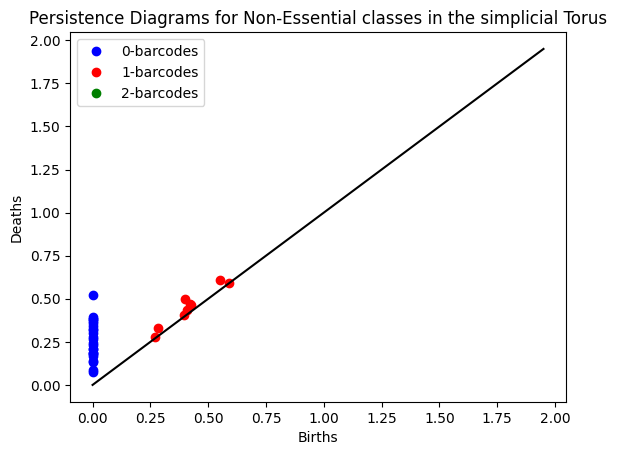

In [36]:
random_dgm_0 = random_dcmp.diagram(random_fil).in_dimension(0)
assert type(random_dgm_0) is np.ndarray
random_dgm_0_x = random_dgm_0[:,0]
random_dgm_0_y = random_dgm_0[:,1]
random_dgm_1 = random_dcmp.diagram(random_fil).in_dimension(1)
random_dgm_1_x = random_dgm_1[:,0]
random_dgm_1_y = random_dgm_1[:,1]
#Alternative notation
random_dgm_2 = random_dcmp.diagram(random_fil)[2]
random_dgm_2_x = random_dgm_2[:,0]
random_dgm_2_y = random_dgm_2[:,1]

print(random_dgm_0)
print(random_dgm_1)
print(random_dgm_2)

# To load the display window
plt.plot(random_dgm_0_x,random_dgm_0_y, 'bo', label = '0-barcodes')
plt.plot(random_dgm_1_x,random_dgm_1_y, 'ro', label = '1-barcodes')
plt.plot(random_dgm_2_x,random_dgm_2_y, 'go', label = '2-barcodes')
X = np.arange(0, 2, 0.05)
Y = X
plt.plot(X,Y, 'k-')
#plt.plot(dgm_2_x,dgm_2_y, 'go', label = '2-barcodes')

plt.xlabel("Births")
plt.ylabel("Deaths")
plt.title("Persistence Diagrams for Non-Essential classes in the simplicial Torus")

plt.legend()

plt.show()

In [38]:
random_Rep_Cocycles = get_Cocycle_Reps(random_dcmp, random_fil, random_V, 2)

for i in range(len(random_Rep_Cocycles)):
    print(random_Rep_Cocycles[i].simplices, random_Rep_Cocycles[i].birth, random_Rep_Cocycles[i].death)

[14954, 14965, 14980, 14991, 14993, 15019, 15038, 15039, 15042, 15051, 15057, 15062, 15065, 15070, 15071, 15091, 15108, 15115, 15140, 15143, 15159, 15180, 15189, 15249] 0.5921485577890132 0.5924800141256829
[724] 0.5517383212991068 0.6073928469400063
[7565] 0.42764735813479127 0.4614353775841774
[10970] 0.4194805339519085 0.46757237541555474
[4042] 0.40872316869534264 0.43248823897430155
[9099] 0.3983561392160871 0.49687023653485457
[153] 0.39412081435111423 0.4058265290738
[12928] 0.2848274086010449 0.32848274244918074
[2499] 0.2702135627780473 0.2760319655102114


In [39]:
random_ReorderedCocycles = sorted(random_Rep_Cocycles, key= lambda x: (x.death, x.birth), reverse=False)

print("")

for i in range(len(random_ReorderedCocycles)):
    print(random_ReorderedCocycles[i].simplices,random_ReorderedCocycles[i].life)



[2499] [np.float64(0.2702135627780473), np.float64(0.2760319655102114)]
[12928] [np.float64(0.2848274086010449), np.float64(0.32848274244918074)]
[153] [np.float64(0.39412081435111423), np.float64(0.4058265290738)]
[4042] [np.float64(0.40872316869534264), np.float64(0.43248823897430155)]
[7565] [np.float64(0.42764735813479127), np.float64(0.4614353775841774)]
[10970] [np.float64(0.4194805339519085), np.float64(0.46757237541555474)]
[9099] [np.float64(0.3983561392160871), np.float64(0.49687023653485457)]
[14954, 14965, 14980, 14991, 14993, 15019, 15038, 15039, 15042, 15051, 15057, 15062, 15065, 15070, 15071, 15091, 15108, 15115, 15140, 15143, 15159, 15180, 15189, 15249] [np.float64(0.5921485577890132), np.float64(0.5924800141256829)]
[724] [np.float64(0.5517383212991068), np.float64(0.6073928469400063)]


In [40]:
random_Cup_diagram = Persistent_Cup_Diagram(4, random_cosimplices, random_R, random_ReorderedCocycles)

random_Cup_diagram_Matrix = random_Cup_diagram[0]
random_b_time = random_Cup_diagram[1]
random_d_time = random_Cup_diagram[2]

print(random_Cup_diagram_Matrix)
print(random_b_time)
print(random_d_time)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[np.float64(0.2702135627780473), np.float64(0.2848274086010449), np.float64(0.39412081435111423), np.float64(0.40872316869534264), np.float64(0.42764735813479127), np.float64(0.4194805339519085), np.float64(0.3983561392160871), np.float64(0.5921485577890132), np.float64(0.5517383212991068)]
[np.float64(0.2760319655102114), np.float64(0.32848274244918074), np.float64(0.4058265290738), np.float64(0.43248823897430155), np.float64(0.4614353775841774), np.float64(0.46757237541555474), np.float64(0.49687023653485457), np.float64(0.5924800141256829), np.float64(0.6073928469400063)]
